In [64]:
import finnhub
import pandas as pd
from time import mktime
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
#Evitar errores
import warnings
warnings.filterwarnings("ignore")

In [66]:
# formato de graficas
sns.set_theme()
sns.set_context("paper")

In [67]:
# api_key de finnhub (https://finnhub.io/dashboard)
finnhub_client = finnhub.Client(api_key="ckuirj9r01qmtr8l8f40ckuirj9r01qmtr8l8f4g")

In [68]:
#stock = 'AAPL' # acciones de apple
stock = 'BINANCE:BTCUSDT'
resolution = 'D' # serie diaria

end_date = datetime.now() #fecha de hoy
#start_date = end_date - timedelta(days=365) # desde hoy con historia de 365
start_date = 1590988249

In [69]:
end = int(end_date.timestamp()) # transforma fecha final unix-time a entero
start = int(start_date.timestamp())# transforma fecha inicial unix-time a entero

AAPL_res = finnhub_client.stock_candles(stock, resolution, start, end) #respuesta 
AAPL_df = pd.DataFrame(AAPL_res) # transformar respuesta  pandas

AAPL_df.head()

AttributeError: 'int' object has no attribute 'timestamp'

In [ ]:
# funcion que transforma fecha int a fecha humana
def date_format(date_col):
    return datetime.fromtimestamp(date_col).strftime('%Y-%m-%d')

In [ ]:
date_format(1602460800)

'2020-10-11'

In [ ]:
AAPL_df['t'] = AAPL_df['t'].apply(date_format) # transforma la columna t a fecha humana con la funcion 'date_format' creada
AAPL_df.head()

,c,h,l,o,s,t,v
0,20591.13,21069.77,20384.89,20905.58,ok,2022-11-06,386977.603370
1,18547.23,20700.88,17166.83,20590.67,ok,2022-11-07,760705.362783
2,15922.81,18587.76,15588.00,18545.38,ok,2022-11-08,731926.929729
3,17601.15,18199.00,15754.26,15922.68,ok,2022-11-09,608448.364320
4,17070.31,17695.00,16361.60,17602.45,ok,2022-11-10,393552.864920


In [ ]:
# renombrar las columnas
AAPL_df.rename(columns = {'c':'Close','h':'High','l':'Low','o':'Open','t':'Date','v':'Volume'}, inplace = True)
AAPL_df.drop('s', axis=1, inplace = True)
AAPL_df.head()

,Close,High,Low,Open,Date,Volume
0,20591.13,21069.77,20384.89,20905.58,2022-11-06,386977.603370
1,18547.23,20700.88,17166.83,20590.67,2022-11-07,760705.362783
2,15922.81,18587.76,15588.00,18545.38,2022-11-08,731926.929729
3,17601.15,18199.00,15754.26,15922.68,2022-11-09,608448.364320
4,17070.31,17695.00,16361.60,17602.45,2022-11-10,393552.864920


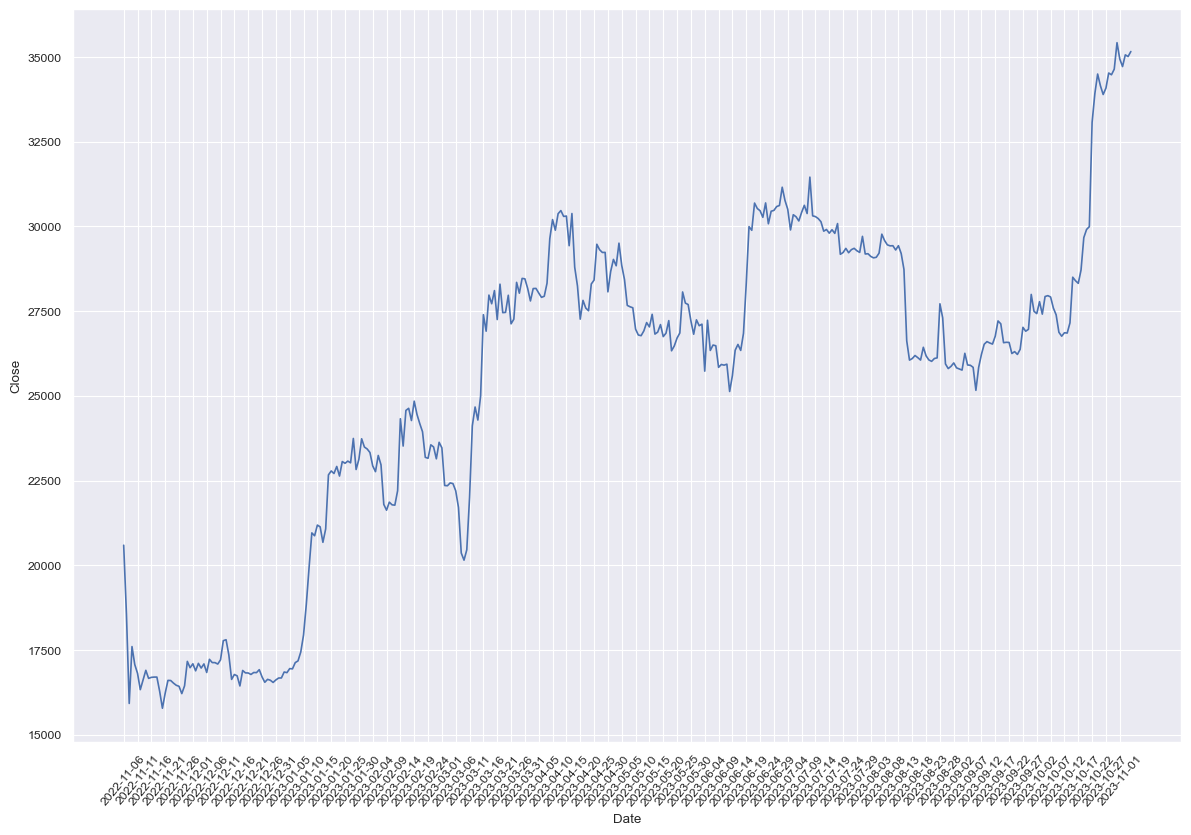

In [ ]:
plt.figure(figsize = (12,8))
ax = sns.lineplot(data=AAPL_df, x="Date", y="Close")
freq = int(5)
xtix = ax.get_xticks() 
ax.set_xticks(xtix[::freq]) # evita que las etiquetas se sobrepongan
plt.tight_layout()
plt.xticks(rotation=50);

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x = AAPL_df.Date,
                                     open = AAPL_df.Open, 
                                     high = AAPL_df.High,
                                     low = AAPL_df.Low, 
                                     close = AAPL_df.Close)
                     ])
fig.update_layout(
    title="Apple Inc. (AAPL)",
    xaxis_title="Day",
    yaxis_title="AAPL-USD",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
# prueba de estacionariedad
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [ ]:
result = adfuller(AAPL_df.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.491082
p-value: 0.893745


La accion de Apple no es estacionaria, el p-valor de la prueba mayor 0.05 no se rechaza la H0 que sugiere estacionariedad con la prueba de dicky-fuller

Valor = 0,668546 > 0,05. Dado que el valor 
 de Adfuller es mayor que un determinado valor alfa especificado (5%, nivel de significación o intervalo de confianza del 95%), se acepta la hipótesis nula 
, es decir, la serie temporal no es estacionaria

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

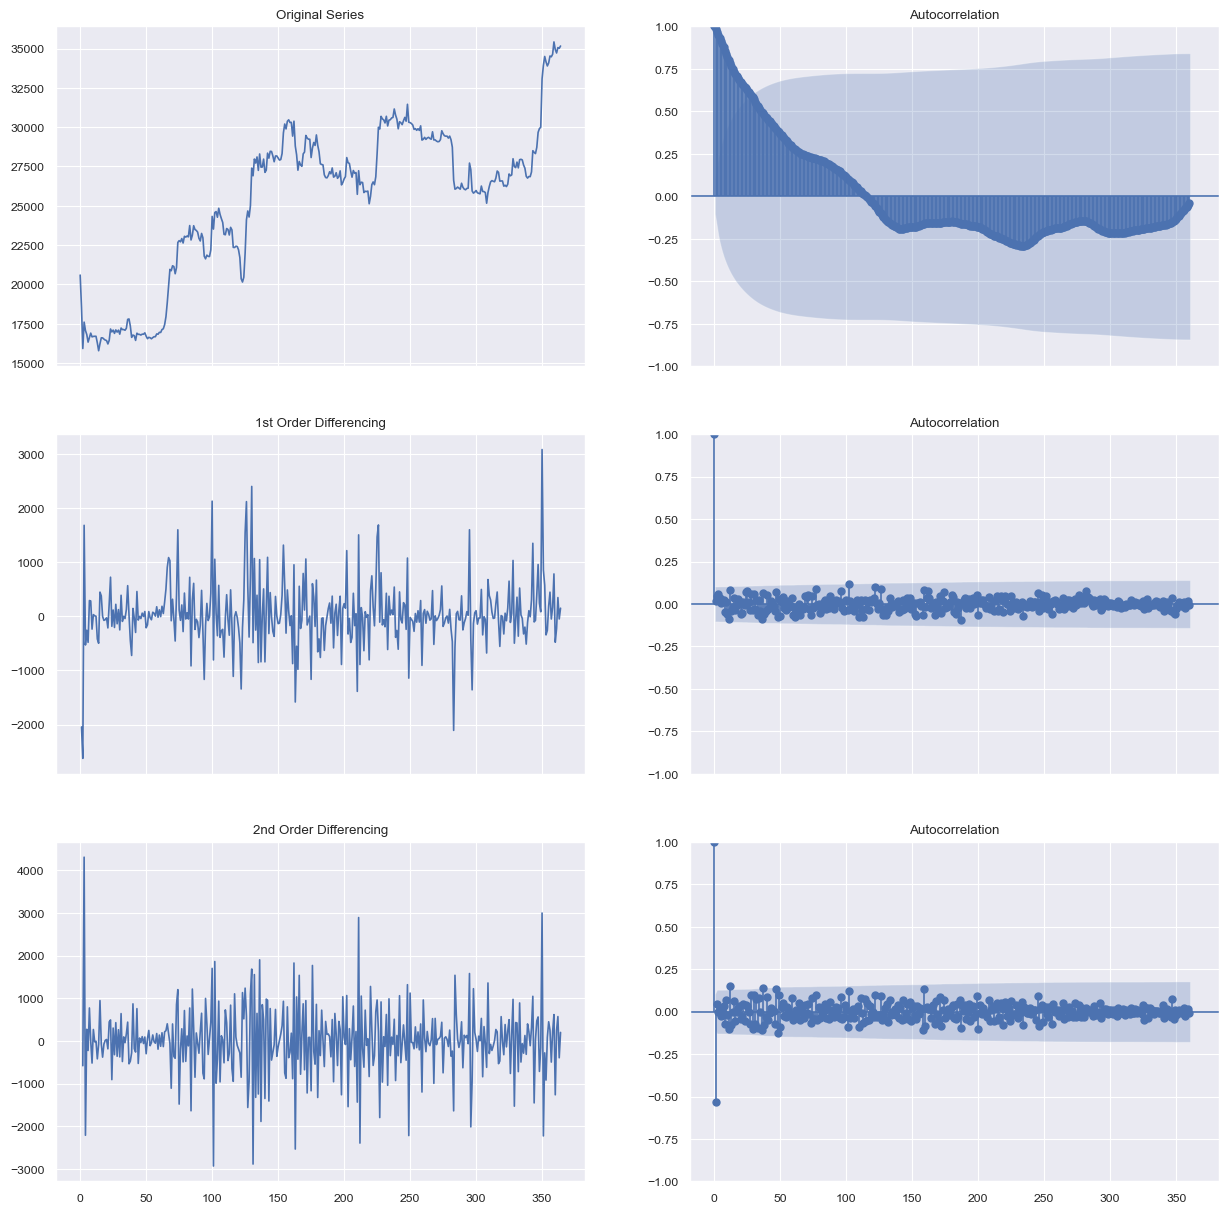

In [ ]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(AAPL_df.Close); axes[0, 0].set_title('Original Series')
plot_acf(AAPL_df.Close, ax=axes[0, 1], lags = 360);

axes[1, 0].plot(AAPL_df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(AAPL_df.Close.diff().dropna(), ax=axes[1, 1], lags = 360);

axes[2, 0].plot(AAPL_df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(AAPL_df.Close.diff().diff().dropna(), ax=axes[2, 1], lags = 360);

In [ ]:
n_AAPL = len(AAPL_df.Close); n_test = 21 # This can be changed
train_size = n_AAPL - n_test

train = AAPL_df.Close.iloc[:train_size]
dates_train = AAPL_df.Date.iloc[:train_size]
test_1w = AAPL_df.Close.iloc[train_size:train_size + n_test] 
dates_1w = AAPL_df.Date.iloc[train_size:train_size + n_test] 
print("train:", train.shape)
print("test_1w:", test_1w.shape)

train: (344,)
test_1w: (21,)


In [ ]:
train_df = AAPL_df[["Date", "Close"]].iloc[:train_size] # enetrenamiento
test_1w_df = AAPL_df[["Date", "Close"]].iloc[train_size:train_size + n_test] # test

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5) # de 0 a 4 preciosa pasados
d_rng  = range(3) # 

for i in pq_rng: #p de ar (autor regresion)
    for d in d_rng: #i de integracion
        for j in pq_rng: #q de ma (media movil)
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic: #tmp_aic inicia en infinito y se compara con cada modelo generado por ARIMA
                    best_aic = tmp_aic #toma el mejor AIC 
                    best_order = (i, d, j) #Toma los mejores parametros
                    best_mdl = tmp_mdl #toma el mejor modelo
            except: continue

In [ ]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 5335.27764 | order: (3, 2, 1)


In [ ]:
import pmdarima as pm

model = pm.arima.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5341.322, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5340.931, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5340.147, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5339.555, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5339.476, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.351 seconds


In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

In [ ]:
model = ARIMA(train, order=best_order)
model_fit = model.fit()

<Figure size 1200x800 with 0 Axes>

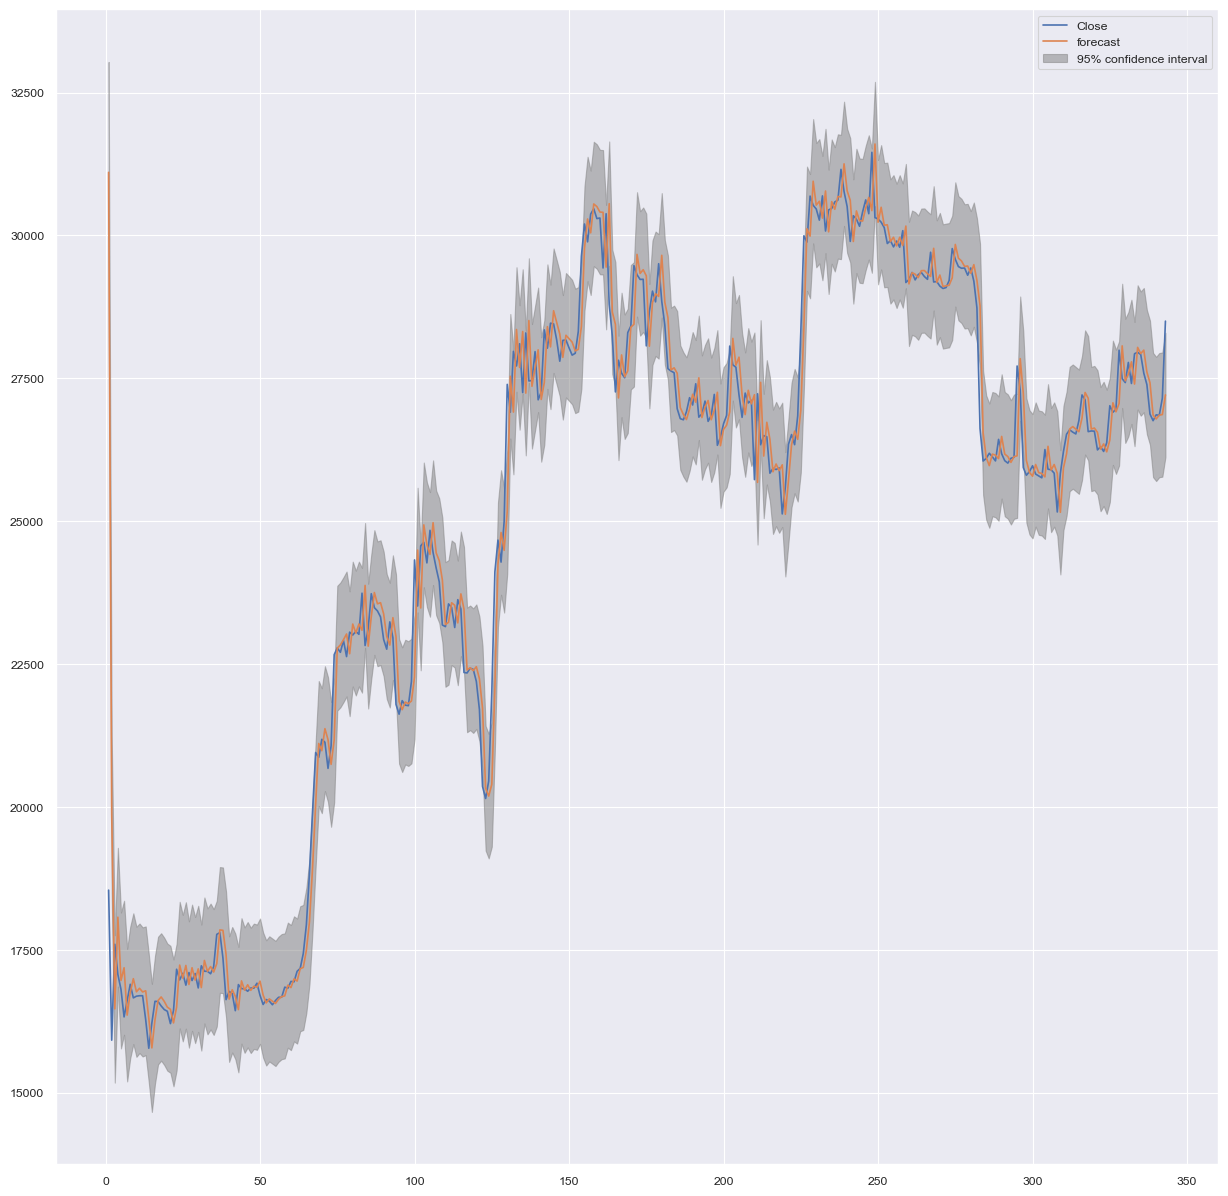

In [ ]:
plt.figure(figsize = (12,8))
fig, ax = plt.subplots()
ax = train.loc[1:].plot(ax=ax)
plot_predict(model_fit, 1, ax=ax)
plt.show();

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [ ]:
def arima_rolling(history, test):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [ ]:
test_1wl = test_1w.tolist()
yhat_1w  = arima_rolling(train.tolist(), test_1wl)

predicted=28591.165059, expected=28395.910000
predicted=28386.656485, expected=28320.000000
predicted=28475.765564, expected=28713.710000
predicted=28761.887475, expected=29669.040000
predicted=29730.102859, expected=29909.800000
predicted=29949.389271, expected=29992.460000
predicted=30109.777705, expected=33069.990000
predicted=33336.911030, expected=33922.730000
predicted=33912.319662, expected=34496.050000
predicted=34918.900730, expected=34151.660000
predicted=34234.583780, expected=33892.020000
predicted=33985.765489, expected=34081.000000
predicted=34118.016483, expected=34525.890000
predicted=34575.649403, expected=34474.730000
predicted=34518.488965, expected=34639.770000
predicted=34744.495586, expected=35421.430000
predicted=35520.128885, expected=34941.590000
predicted=34938.458129, expected=34716.780000
predicted=34842.566338, expected=35062.070000
predicted=35097.042902, expected=35011.880000
predicted=35018.981971, expected=35160.330000


In [ ]:
forecast_accuracy(np.array(test_1wl), np.array(yhat_1w), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,453.22938,582232.087224,0.014176,763.04134,0.906148


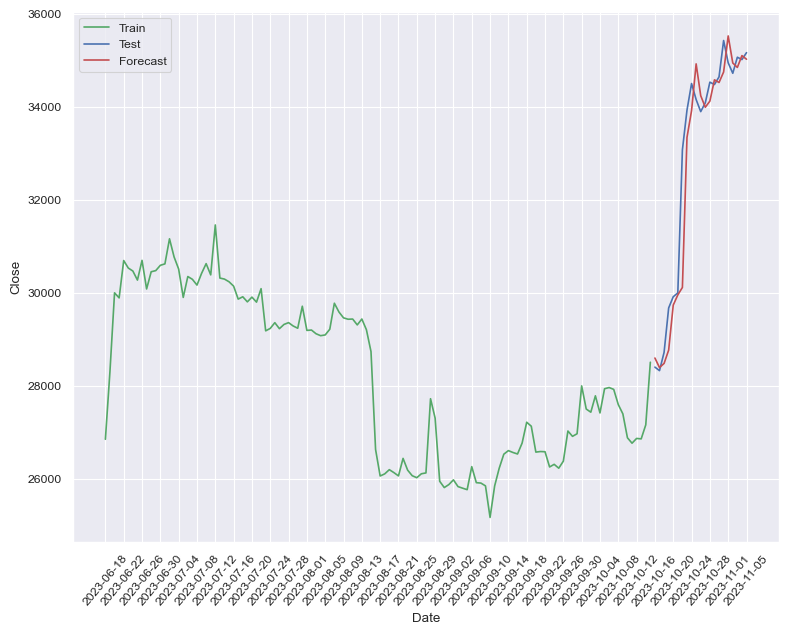

In [ ]:
plt.figure(figsize = (8, 6))
ax = sns.lineplot(x=dates_train[-120:], y=train[-120:], label="Train", color='g')
sns.lineplot(x=dates_1w, y=test_1wl, label="Test", color='b')
sns.lineplot(x=dates_1w, y=yhat_1w, label="Forecast", color='r')
freq = int(4)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
plt.tight_layout()
plt.xticks(rotation=50);